In [1]:
'''Find microburst peaks'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
import scipy.optimize
import scipy.signal
import sklearn.metrics
import sampex
from scipy.integrate import quad
import warnings

class ID_Microbursts:
    # tell the class the properties you wanna store in here preliminarily.
    def __init__(self, h, packet_timestamp, prominence_rel_height=0.5):
        self.h = h # assign HILT data object to self.h
        self.packet_timestamp = packet_timestamp # assign packet start timestamp
        self.prominence_rel_height=prominence_rel_height # assign prominence height width evaluator
        #(when you find a peak, you measure the width at this % the full prominence.
        # Default is 0.5, 0 would be the base, 1 would be the top.)
        return

    def obrien(self): # O'Brien et al. 2003 criterion, modified to catch lower-count-rate instances
        N20 = self.h['counts'] # count rate sampled every 20 ms
        time20 = self.h['time'] # time every 20 ms

        df = pd.DataFrame({'time': self.h['time'], 'counts': self.h['counts']})

        df.set_index('time', inplace=True) # set time column as the index

        # resample the dataframe to 100 ms intervals and sum the counts in each interval
        N100 = df.resample('100ms').sum()

        A500 = N100.rolling(5, center=True).mean() # 5-observation centered rolling mean (over 500 ms)

        # O'Brien et al 2003
        condition = np.divide((N100.counts - A500.counts), np.sqrt(1 + A500.counts)) 

        ns = np.where(condition > 5)[0] # RHS changed from 10 to 5
        
        epsilon = 10; # if two flagged indices are spaced less than this distance apart, 
        # they are probably part of the same microburst

        starts = [] # initializing
        ends = []

        dn = np.diff(ns) # difference in time between instances of the condition being true

        # finding extended periods of the condition being true
        for i in np.arange(1,len(dn)-10):
            if dn[i] < epsilon and dn[i+1] < epsilon and dn[i-1] >= epsilon: # start condition
                starts.append(ns[i])
                for j in np.arange(i+1, len(dn)-1):
                    if dn[j] < epsilon and dn[j+1] >= epsilon:
                        ends.append(ns[j]) # end condition
                        break
            elif dn[i] <= epsilon and i == 1: # start condition (edge case)
                starts.append(ns[i])
                for j in np.arange(i+1, len(dn-1)):
                    if dn[j] <= epsilon:
                        ends.append(ns[j])
                        break
            elif i == len(dn): # end condition (edge case)
                ends.append(ns[i])

        if len(starts) > len(ends):
            ends.append(starts[len(starts)-1] + 10)

        starts = [x - 2 for x in starts] # pad start times with 0.2 seconds 
        ends = [x + 10 for x in ends] # pad end times with 1 second


        def changeCadence(time20, times100):
            # times100 is the list of timestamps for whatever it is: starts, ends, ns
            # times20 is the entire list of time20 for the day in question
            try:
                # try list comprehension first, it's faster
                idx20 = [time20.get_loc(tstmp) for tstmp in times100] 
            except: 
                # if a timestamp is missing from time20, find the closest timestamp 
                idx20 = [] # clear and start over
                idx20 = [np.abs((time20 - target).values).argmin() for target in times100] 
            return idx20

        # reverting indices to 20 ms cadence
        self.so = changeCadence(time20, N100.index[starts])
        self.eo = changeCadence(time20, N100.index[ends])
        self.no = changeCadence(time20, N100.index[ns])
        return
    
    
    def find_microbursts(self):
        # Author: Max Feinland
        # Date created: 10/11/2024
        # Last modified:
        # Purpose: finds microbursts, returns indices containing peaks.
        
        self.obrien() # call O'Brien function-- now self contains so, eo, no
        #(start times as identified by O'Brien, end times as identified by O'Brien, 
        # all indices that meet the condition as identified by O'Brien)
        
        t = self.h['times'] # pull out time data
        rate = self.h['counts'] # pull out count rate data
        
        # Returns the index corresponding to the start of the O'Brien ID'd packet.
        # mbidx stands for "microburst index" since I know that's not really clear
        mbidx =  np.abs((t[self.so] - self.packet_timestamp).values).argmin()
        
        interval = rate[self.so[mbidx]:self.eo[mbidx]] # define just one chunk of the rate data, 
        # taken from O'Brien interval
        
        maxdis = max(interval) - min(interval) # use to generate prominence requirement

        # finding peaks with a high enough prominence
        [pks, _] = find_peaks(interval, prominence=0.25*maxdis, distance=3)

        # find instances where a bunch of peaks are evenly spaced (at least 4 peaks)
        indices = np.where(np.convolve(np.abs(np.diff(np.diff(pks))) <= 3, \
                                               np.ones(2), mode='valid') == 2)[0]
        indices = np.append(indices, [indices[-1]+1, indices[-1]+2, indices[-1]+3])
        
        pks = pks[indices] # pks is a list of indices in the HILT data that has a peak
        # that meets all these conditions. (o'brien, high enough prominence, evenly spaced)

        # Add peak_idx to self-- a list of indices in the HILT dataframe containing peaks
        # (add self.so[mbidx] b/c that's the beginning of the interval)
        self.peak_idx = list(self.so[mbidx] + loc for loc in pks)
        
        # Convert HILT objects to dataframe
        hilt_df = pd.DataFrame(data={'counts':h.counts}, index=self.h['time'])

        # call an instance of Do_Gaussian class using the day's HILT data, 
        # the list of peak indices, and the prominence width 
        # (how high up the peak, 0 to 1 where 0 is the base and 1 is the top, to evaluate the width)
        gaus = Do_Gaussian(hilt_df, self.peak_idx, self.prominence_rel_height)
        
        # Calculate widths using scipy.signal.peak_widths
        gaus.calc_prominence_widths()
        
        # Using this initial estimate, calculate widths using Gaussian fit
        fit_df, tr = gaus.calc_gaus_widths()

        self.props = fit_df # assign attribute 'props' to self
        # (contains information about the fit of the peaks: r^2, amplitude, center, width, etc.)
        # return tr (time range)
        '''Rename tr????'''
        return hilt_df, tr


class Do_Gaussian:
    def __init__(self, hilt_df, peak_idx, prom_h, width_multiplier=2.5, plot_width_s=5):
        """
        Initialize Do_Gaussian class instance with these variables
        """
        self.hilt_df = hilt_df # HILT dataframe
        self.peak_idx = peak_idx # peak indices
        self.prominence_rel_height = prom_h # prominence height to evaluate width
        self.width_multiplier = width_multiplier
        self.plot_width_s = plot_width_s
        self.hilt_times = self.hilt_df.index.to_numpy()
        return

    def calc_prominence_widths(self):
        # Author: Mike Shumko
        # Date created: unknown
        # Last modified: 10/11/2024 by Max Feinland
        # Purpose: Use scipy to find the peak width at self.prominence_rel_height prominence.

        # Check that self.peak_idx correspond to the max values
        peak_check_thresh = 5 # Look 100 ms around the peak count to find the true peak. 
        for i, index_i in enumerate(self.peak_idx):
            self.peak_idx[i] = index_i - peak_check_thresh + \
                np.argmax(self.hilt_df['counts'][index_i-peak_check_thresh:index_i+peak_check_thresh])
        
        # Use scipy to find the peak width at self.prominence_rel_height prominence
        widths_tuple = scipy.signal.peak_widths(self.hilt_df['counts'], self.peak_idx, 
                                            rel_height=self.prominence_rel_height)
        
        self.prom_widths_s = 20E-3*widths_tuple[0]   
        self.width_height = widths_tuple[1]
        self.left_peak_base = self.hilt_times[np.round(widths_tuple[2]).astype(int)]
        self.right_peak_base = self.hilt_times[np.round(widths_tuple[3]).astype(int)]  
        return

    def calc_gaus_widths(self, detrend=True):
        # Author: Mike Shumko
        # Date created: unknown
        # Last modified: 10/11/2024 by Max Feinland
        # Purpose: Use prior estimates from scipy estimation to find peak widths, amplitude, 
        # center, opt. linear trend using Gaussian fit.
        
        if not hasattr(self, 'prom_widths_s'):
            raise AttributeError('No prior width estimate exists. Run the '
                                'calc_prominence_widths method first.')

        # Create empty pd.DataFrames for fit variables.
        fit_param_names = ['r2', 'adj_r2', 'A', 't0', 'fwhm']
        if detrend:
            fit_param_names.extend(['y-int', 'slope'])
        df = pd.DataFrame(data={key:np.nan*np.ones_like(self.peak_idx) 
                        for key in fit_param_names}, index=self.peak_idx)

        # Loop over every peak
        time_total = []
        for i, (peak_i, width_i, height_i) in enumerate(zip(self.peak_idx, self.prom_widths_s, self.width_height)):
            time_range = [self.left_peak_base[i] - pd.Timedelta(seconds=0.06), 
                          self.right_peak_base[i] + pd.Timedelta(seconds=0.08)]

            width_i = pd.Timedelta(time_range[1] - time_range[0]).total_seconds()/1.5

            t0 = self.hilt_times[peak_i]

            if detrend:
                p0 = [
                    height_i,   # gauss amplitude 
                    t0,         # gauss center time
                    width_i,    # 2x gaus std.
                    self.hilt_df.loc[time_range[0]:time_range[1], 'counts'].median(), # y-intercept
                    0           # Slope
                    ]
            else:
                p0 = [height_i, t0, width_i]
                

            # Catch warnings
            with warnings.catch_warnings(record=True) as w:
                # Catch exceptions
                try:
                    popt, pcov, r2, adj_r2 = self.fit_gaus(time_range, p0)
                            
                except RuntimeError as err:
                    if ('Optimal parameters not found: Number of calls '
                        'to function has reached maxfev') in str(err):
                        continue
                    raise
                if len(w):
                    print(w[0].message, '\n', p0, popt)

            # Save to a pd.DataFrame row.
            if popt[2] < 0:
                popt[2] = popt[2]*-1
                
            area = popt[0]
            df.iloc[i, :2] = r2, adj_r2
            df.iloc[i, 2:] = popt 

            time_total.append(time_range)
        return df, time_total

    def fit_gaus(self, time_range, p0):
        # Author: Mike Shumko
        # Date created: unknown
        # Last modified: 10/11/2024 by Max Feinland
        # Purpose: Fits a gaussian shape with an optional linear detrending term.

        x_data = self.hilt_df.loc[time_range[0]:time_range[1], :].index
        current_date = x_data[0].floor('d')
        x_data_seconds = (x_data-current_date).total_seconds()
        y_data = self.hilt_df.loc[time_range[0]:time_range[1], 'counts']

        if len(x_data) < len(p0):
            raise ValueError('Not enough data points to fit. Increase the '
                            'time_range or self.width_multiplier')

        p0[0] *= 2
        p0[1] = (p0[1] - current_date).total_seconds()
        p0[2] = p0[2]/2 # Convert the microburst width guess to ~std.

        if p0[2] > 1: # width too big
            p0[2] = 0.1 # more reasonable estimate

        popt, pcov = scipy.optimize.curve_fit(Do_Gaussian.gaus_lin_function, 
                                                x_data_seconds, y_data, p0=p0, maxfev=5000, 
                                                bounds=([50, 0, 0.015, -np.inf, -np.inf], 
                                                    [10000, np.inf, 1, np.inf, np.inf]))
        popt_np = -1*np.ones(len(popt), dtype=object)
        popt_np[0] = popt[0]
        popt_np[1] = current_date + pd.Timedelta(seconds=float(popt[1]))
        popt_np[2] = (2*np.sqrt(2*np.log(2)))*popt[2]
        
        if popt_np[2] > 0.2:
            # width TOO BIG. make that boy smaller
            popt_np[2] = 0.15
        
        if len(popt) == 5:
            # If superposed a Gaussian on a linear trend...
            popt_np[3:] = popt[3:]

        y_pred = Do_Gaussian.gaus_lin_function(x_data_seconds, *popt)
        
        try:
            r2, adj_r2 = self.goodness_of_fit(y_data, y_pred, len(popt))
        except ValueError as err:
            if 'Input contains NaN, infinity or a value too large' in str(err):
                print(f'popt={popt}')
                print(f'y-data={y_data}')
                print(f'y_pred={y_pred}')
            raise
        return popt_np, np.sqrt(np.diag(pcov)), r2, adj_r2

    @staticmethod # I think this line just avoids passing "self" to these functions below
    
    def gaus_lin_function(t, *args):
        # Author: Mike Shumko
        # Purpose: Fits a gaussian shape with an optional linear detrending term.

        """
        Args is an array of either 3 or 5 elements. First three elements are
        the Gaussian amplitude, center time, and width. The last two optional
        elements are the y-intercept and slope for a linear trend. 
        """
        
        exp_arg = -(t-args[1])**2/(2*args[2]**2)
        y = args[0]*np.exp(exp_arg)

        if len(args) == 5:
            y += args[3] + t*args[4]
            
        '''Add functionality to calculate area??'''
            
        return y


    def goodness_of_fit(self, y_true, y_pred, n_params):
        # Author: Mike Shumko
        # Purpose: Evaluate goodness of Gaussian fit (returns R^2, adjusted R^2)

        """
        Method to calculate the R^2 coefficient of determination
        and the adjusted R^2 coefficient given the number
        of fit parameters n_params.
        """
        r2 = sklearn.metrics.r2_score(y_true, y_pred)
        n = len(y_true)
        adj_r2 = 1 - (1-r2)*(n-1)/(n-1-n_params)
        return r2, adj_r2

In [56]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def gaus_overlay_plot(props_df, hilt_df, ax, time_range):
    # Original author: Mike Shumko
    # Date created: unknown
    # Last modified: 10/11/2024 by Max Feinland
    # Purpose: Plots fitted Gaussian curves over raw HILT data.

    plot_start_time = props_df.t0.iloc[0] - pd.Timedelta(seconds=1)
    u = np.where(hilt_df.index.duplicated()==True)[0]
    df_idx = hilt_df.index[u]
    hilt_df = hilt_df.drop(index=df_idx) # get rid of duplicate indices

    closest_start_idx = hilt_df.index.get_indexer([plot_start_time], method='nearest')[0]
    plot_end_time = props_df.t0.iloc[-1] + pd.Timedelta(seconds=1)
    closest_end_idx = hilt_df.index.get_indexer([plot_end_time], method='nearest')[0]
    plot_time_range = [hilt_df.index[closest_start_idx], hilt_df.index[closest_end_idx]]
    
    time_array = hd.loc[plot_time_range[0]:plot_time_range[-1]].index
    current_date = time_array[0].normalize()
    x_data_seconds = (time_array-current_date).total_seconds()
    y_data = hd.loc[plot_time_range[0]:plot_time_range[1], 'counts']
    ax.plot(time_array, y_data, c='k', label='HILT data')
    
    solid_counter = 0
    dashed_counter = 0
    
    for i in range(len(props_df)): # Loop through each peak
        popt = [props_df.iloc[i, 2], props_df.iloc[i, 3], props_df.iloc[i, 4], 
                props_df.iloc[i, 5], props_df.iloc[i, 6]]

        pdate = popt[1] # t0 in datetime terms
        popt[1] = (popt[1] - current_date).total_seconds()
        popt[2] = popt[2]/2.355 # Convert the Gaussian FWHM to std

        gaus_y = Do_Gaussian.gaus_lin_function(x_data_seconds, *popt)

        t_start = np.where(time_array==time_range[i][0])[0][0]
        t_end = np.where(time_array==time_range[i][1])[0][0]


        # If r^2 too low, plot dashed line
        if i in good_pks_f:
            line_style = '-'
            alpha_level = 1
            solid_counter += 1
            if solid_counter > 1: # Check if one of these has been done already.
                labl=None
            else:
                labl='Gaussian fit ($r^2 > 0.8$)'
        else:
            line_style = '--'
            alpha_level = 0.5
            dashed_counter += 1
            if dashed_counter > 1:
                labl = None
            else:
                labl = 'Gaussian fit ($r^2 < 0.8$)'
        ax.plot(time_array[t_start:t_end], gaus_y[t_start:t_end], 
                           c='r', linestyle=line_style, alpha=alpha_level, label=labl)

        baseline = hd.counts[time_range[0][0]]

        ax.text(pdate, popt[0]+baseline, str(i+1))
        # end of for loop
    ax.set_ylim(min(y_data)*0.8, max(y_data)*1.2)
    formatter = mdates.DateFormatter('%H:%M:%S') # 1 decimal place
    ax.xaxis.set_major_formatter(formatter)
    ax.grid()
    plot_date_string = 'Time on ' + current_date.strftime('%Y/%m/%d') 
    ax.set_xlabel(plot_date_string)
    ax.set_ylabel('Counts (#/20 ms)')

    ax.legend() 
    ax.set_xlim(time_array[0], time_array[-1])
    plt.show()
    return 

Microburst 44
bad_2


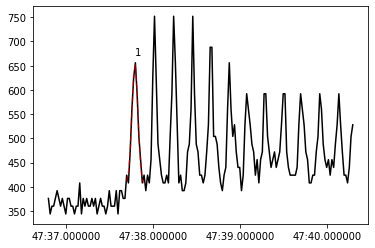

In [83]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import sampex
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Read in data
events = pd.read_csv('lshelldata.csv')

# See if you need to load each HILT object (takes awhile, better if you can avoid it)
if 'nums' in globals():
    old_nums = nums
else:
    old_nums = []
nums = range(44, 45) # events to look at

if (old_nums == nums) & (len(nums)==1):
    load_each = False
else:
    load_each = True


w = []
s = []
t = []

for i in nums:
    print('Microburst', i)
    date = datetime.strptime(events.date[i], "%m/%d/%Y") # change to list iteration for all events
    sstr = events.date[i] + ' ' + events.time[i]
    timestamp = datetime.strptime(sstr, "%m/%d/%Y %H:%M:%S")
    
    if load_each:
        h = sampex.HILT(date)
        h.load()

    obj = ID_Microbursts(h, timestamp)
    
    bad = False # assume everything works at first

    try:
        hd, tr = obj.find_microbursts()
    except:
        bad = True
        print('bad')
        
    if not bad:

        fit = obj.props # data about each curve fit

        # remove poorly-fitted peaks
        good_pks = np.where(fit['r2'] > 0.8)[0]

        # Initialize an empty list to store filtered results
        good_pks_f = []

        # Iterate through good_x and only keep values that are adjacent (spaced by 1 index)
        for i in range(0, len(good_pks)):
            if i == len(good_pks)-1:
                if good_pks[i] - good_pks[i-1] == 1:
                    good_pks_f.append(good_pks[i])
            else:
                if good_pks[i+1] - good_pks[i] == 1:  # Only keep if spaced by 1 index
                    good_pks_f.append(good_pks[i])

        fig, ax = plt.subplots()
        
        bad_2 = False
        try:
            gaus_overlay_plot(fit, hd, ax, tr)
            plt_name = date.strftime('%Y_%m_%d.jpg')
#             fig.savefig('fit pics/' + plt_name)
        except:
            bad_2 = True # failed
            print('bad_2')
        
        if not bad_2:
            w_i = fit['fwhm'].values # peak widths
            w_i = np.round(w_i[good_pks_f], 4) # restrict to good pks only, and round values
            w.append(list(w_i)) # add to big array

            # peak spacings
            dt = np.diff(fit.t0)
            s_i = [x.total_seconds() for x in dt]
            s_i.append(None) # add one bc length is len(w)-1 since it's spacing BW peaks
            # need this so that the next line doesn't throw an out-of-bounds index error.
            s_i = [s_i[x] for x in good_pks_f]
            s.append(s_i)
            t.append(timestamp)

w_s = pd.DataFrame({'t': t, 'w': w, 's': s})


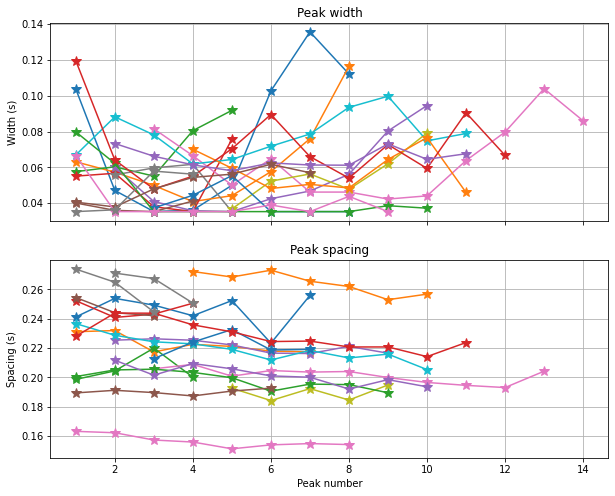

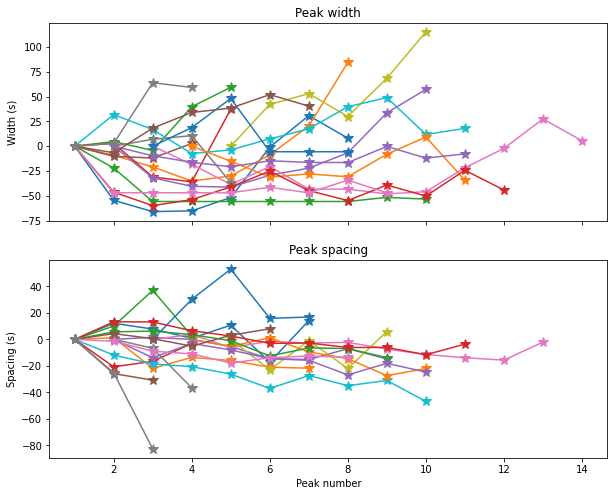

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('w_s.csv', index_col=0)
idx = np.where((df.y==1) & (df.sh=="crown"))[0]
df = df.iloc[idx,:] # restrict to good events & crowns
df = df.reset_index(drop=True)

fig1, ax1 = plt.subplots(2, figsize=(10,8), sharex=True)
fig2, ax2 = plt.subplots(2, figsize=(10,8), sharex=True)

for i in range(len(df)):
    pks = eval(df.pk[i])
    w = eval(df.w[i])
    s = eval(df.s[i])
    s = s[0:len(s)-1] # get rid of NoneType
    
    ax1[0].plot(pks, w, '*-', markersize=10)
    ax1[0].set_ylabel('Width (s)')
    ax1[0].set_title('Peak width')

    ax1[1].plot(pks[0:len(pks)-1], s, '*-', markersize=10, label=str(i))
    ax1[1].set_xlabel('Peak number')
    ax1[1].set_ylabel('Spacing (s)')
    ax1[1].set_title('Peak spacing')
    
    delta_w = [100*(x - w[0])/w[0] for x in w]
    delta_s = [100*(x - s[0])/w[0] for x in s]
    
    ax2[0].plot(pks, delta_w, '*-', markersize=10)
    ax2[0].set_ylabel('Width (s)')
    ax2[0].set_title('Peak width')

    ax2[1].plot(pks[0:len(pks)-1], delta_s, '*-', markersize=10, label=str(i))
    ax2[1].set_xlabel('Peak number')
    ax2[1].set_ylabel('Spacing (s)')
    ax2[1].set_title('Peak spacing')

ax1[1].grid()
ax1[0].grid()


[0.1037, 0.0471, 0.0353, 0.0361, 0.05, 0.1027, 0.1356, 0.1121]
[0.0631, 0.0573, 0.0499, 0.0409, 0.0442, 0.0576, 0.076, 0.1164]
[0.0576, 0.0603, 0.0551, 0.0805, 0.0918]
[0.0551, 0.0567, 0.038, 0.0353, 0.0757]
[0.0601, 0.0409, 0.0358, 0.0353, 0.0425, 0.0468, 0.0561, 0.0803, 0.0945]
[0.0525, 0.0403, 0.0375, 0.0596, 0.0377]
[0.0401, 0.036, 0.0353, 0.0412]
[0.07, 0.0521, 0.0607, 0.0353]
[0.0828, 0.0603, 0.0461, 0.0547, 0.0434, 0.064, 0.0353]
[0.0523, 0.054, 0.0534, 0.0353]
[0.0428, 0.0353, 0.0395, 0.0353, 0.0353]
[0.0712, 0.1168, 0.0878, 0.0693]
[0.0815, 0.0665, 0.0501, 0.0648, 0.0462, 0.0462, 0.0423, 0.0441, 0.0638, 0.0797, 0.1039, 0.086]
[0.0768, 0.0705]
[0.0884, 0.0597, 0.062, 0.0639, 0.0656, 0.0972, 0.0733, 0.0775, 0.0709]
[0.0798, 0.1235, 0.0898, 0.0931, 0.0911, 0.1038]
[0.0558, 0.0597, 0.0617, 0.0353]
[0.067, 0.105, 0.0917, 0.0805, 0.1026, 0.0781, 0.0819]
[0.116, 0.0703, 0.0657, 0.0483, 0.0659, 0.053, 0.0622, 0.0732]
[0.0358, 0.0449, 0.0611, 0.044, 0.0514, 0.0353, 0.0485]
[0.0368, 0.0

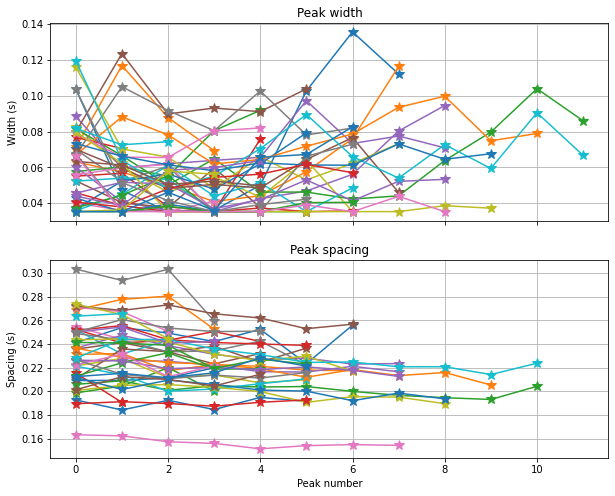

In [74]:
df = pd.read_csv('w_s.csv')

fig, ax1 = plt.subplots(2, figsize=(10,8), sharex=True)

for i in range(len(w_s)):
    print(w_s.w[i])
    ax1[0].plot(range(len(w_s.w[i])), w_s.w[i], '*-', markersize=10, label=str(i))
#     ax1[0].set_xlabel('Peak number')
    ax1[0].set_ylabel('Width (s)')
    ax1[0].set_title('Peak width')
#     ax1[0].legend()
#     ax1[0].set_ylim(0, 0.15)
    
    ax1[1].plot(range(len(w_s.s[i])), w_s.s[i], '*-', markersize=10, label=str(i))
    ax1[1].set_xlabel('Peak number')
    ax1[1].set_ylabel('Spacing (s)')
    ax1[1].set_title('Peak spacing')
#     ax1[1].legend()
#     ax1[1].set_ylim(0, 0.4)
ax1[1].grid()
ax1[0].grid()

In [81]:
w_s.to_csv('w_s.csv')

Text(0.5, 1.0, 'Peak spacing')

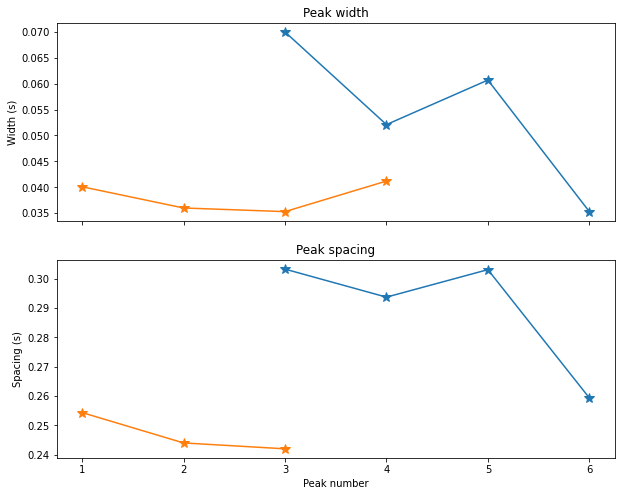

In [85]:
t1 = '1999-11-08 23:13:00'
pks1 = [3, 4, 5, 6]
pks2 = [1, 2, 3, 4]
w2 = [0.0401, 0.036, 0.0353, 0.0412]
s2 = [0.254358, 0.244014, 0.242008, None]
w1 = [0.07, 0.0521, 0.0607, 0.0353]
s1 = [0.303233, 0.293683, 0.303051, 0.259349]
fig1, ax2 = plt.subplots(2, figsize=(10,8), sharex=True)

#     print(w_s.w[i])
ax2[0].plot(pks1, w1, '*-', markersize=10, label=str(i))
ax2[0].plot(pks2, w2, '*-', markersize=10, label=str(i))
# ax1[0].set_xlabel('Peak number')
ax2[0].set_ylabel('Width (s)')
ax2[0].set_title('Peak width')
#     ax1[0].legend()
#     ax1[0].set_ylim(0, 0.15)
    
ax2[1].plot(pks1, s1, '*-', markersize=10, label=str(i))
ax2[1].plot(pks2, s2, '*-', markersize=10, label=str(i))
ax2[1].set_xlabel('Peak number')
ax2[1].set_ylabel('Spacing (s)')
ax2[1].set_title('Peak spacing')
#     ax1[1].legend()
#     ax1[1].set_ylim(0, 0.4)